# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [8]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob

# Extra imports
from torchsummary import summary

In [9]:
# Just some code to print out the progress of a process as a loading bar
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 50, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [10]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    indices = list(range(0, lendata))
    np.random.shuffle(indices)
    train_len = int(lendata * percentage)
    return indices[:train_len], indices[train_len:]

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)

# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set

        self.path_to_images = path_to_images
        self.idxs_train = idxs_train
        self.idxs_test = idxs_test
        self.transform_extra = transform_extra
        self.img_size = img_size
        self.train = train

        # Stores data about each class in the form of [total number of images, number of images in training data, example image]
        self.class_sizes = {name: [0, 0, None] for name in Multiclass_labels_correspondances.keys()}

        # Data collected to show the progress bar when running code
        self.total_files = 0
        for root, _, files in os.walk(self.path_to_images, topdown=False):
            label = os.path.basename(root)
            if label in Multiclass_labels_correspondances:
                self.total_files += len(files)
        
        images = []
        images_done = 0 # Counter used for progress bar
        for root, _, files in os.walk(self.path_to_images, topdown=False):
            label = os.path.basename(root)
            if label in Multiclass_labels_correspondances:
                self.class_sizes[label][0] = len(files) # Update total number in class
                label_idx = Multiclass_labels_correspondances[label]
                for name in files:

                    # Update total number in training for this class
                    if images_done in self.idxs_train:
                        self.class_sizes[label][1] += 1                        

                    # Load all the images and their labels
                    image = Image.open(os.path.join(root, name).replace("\\","/"))
                    # scaling instead of cropping and resizing to prevent cropping of key interest points
                    image = image.resize((self.img_size, self.img_size))
                    image = image.copy()

                    # Add the image as an example for showing data below
                    if self.class_sizes[label][2] is None:
                        tensorfy = transforms.ToTensor()
                        self.class_sizes[label][2] = tensorfy(image)
            
                    # Append copies list with tuple
                    images.append((image, label_idx))

                    # Update progress bar
                    images_done += 1
                    printProgressBar(images_done, self.total_files, suffix=f"Current class: {label}\t\t\t")

        # Extract the images and labels with the specified file indexes  
        self.training_set = [images[i] for i in self.idxs_train]
        self.test_set = [images[i] for i in self.idxs_test]
        
    def __len__(self):
        # Return the number of samples
        return len(self.training_set) if self.train else len(self.test_set)
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the image and its label
        img, i = self.training_set[idx] if self.train else self.test_set[idx]
        if self.transform_extra:
            img = self.transform_extra(img)
        
        return (img, i)

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

In [11]:
# Training set
img_path = './archive/Fish_Dataset/Fish_Dataset'
dataset  = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)


 |██████████████████████████████████████████████████| 100.0% Current class: Trout			ed Mullet			


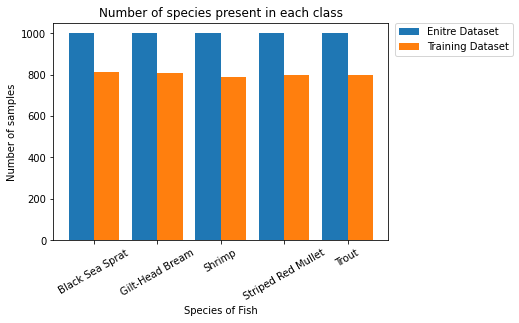

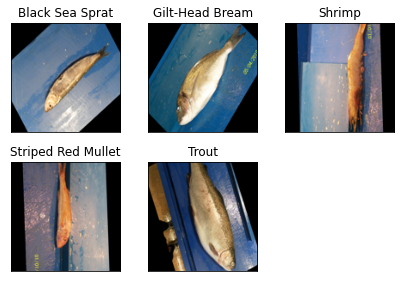

In [12]:
# Plot the number of samples per class
hist_data = dataset.class_sizes

# It was not specified if we should plot the number of images per class in the whole dataset
# or just the training data and so I have printed both next to each other in a bar graph
classes = list(hist_data.keys()) # Class names
total = [x[0] for x in hist_data.values()] # Number of images per class in the whole dataset
train = [x[1] for x in hist_data.values()] # Number of images per class in the training dataset
x_axis = np.arange(len(classes))

plt.bar(x_axis - 0.2, total, 0.4, label="Enitre Dataset")
plt.bar(x_axis + 0.2, train, 0.4, label="Training Dataset")

plt.xticks(x_axis, classes, rotation=30)

plt.xlabel("Species of Fish")
plt.ylabel("Number of samples")
plt.title("Number of species present in each class")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# Plot 1 sample from each of the five classes in the training set
for i, (name, (_, _, image)) in enumerate(hist_data.items()):
    plt.subplot(2,3,i+1)
    fig = plt.imshow(image.permute(1, 2, 0))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(name)
    plt.tight_layout(pad=1.0)


### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

The dataset is balanced. As you can see there the same number of photos in each class in the whole dataset (1,000 per class) and each class of the training data also has around the same number of images present (800 on average). <br>

If the data was not balanced we could do one of three methods to make it balanced:
1. We could downsample the larger classes to the size of the smallest class through random selection. However, this will lead to less training data and a potentially less accurate model as essential data may be lost.  
2. We could upscale the smaller classes by duplicating some of the images to balance out the total numbers. However, this comes with a loss of generality and may lead to the model overfitting due to seeing multiple of the same images.
3. Finally, we could used weighted costs depending on how many samples there are in each class to ensure that the smaller classes have a greater change in  weights as there are fewer of them.

The data is alredy preprocessed as all the images are the same size of 590 x 445 pixels while also having an equal number of images in each class.

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [13]:
class Net(nn.Module):
    def __init__(self, output_dims=1):
        super(Net, self).__init__()
        self.feature_extraction = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.Tanh()
        )

        self.classification = nn.Sequential(
            nn.Linear(in_features=120 * 25 * 25, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=output_dims),
        )

    def forward(self, x):
        x = self.feature_extraction(x)
        x = torch.flatten(x, 1)
        x = self.classification(x)
        return x

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [23]:
# Network
model = Net(output_dims=len(Multiclass_labels_correspondances)).to(device=torch.device(device))

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Number of iterations for training
epochs = 50

# Training batch size
train_batch_size = 100

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = FishDataset(img_path, idxs_train, idxs_test, transform_extra=transforms.ToTensor(), img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, transform_extra=transforms.ToTensor(), img_size=128, train=False)
test_dataloader = DataLoader(test_dataset)

summary(model, input_size=(3, 128, 128))

 |██████████████████████████████████████████████████| 100.0% Current class: Trout			ed Mullet			
 |██████████████████████████████████████████████████| 100.0% Current class: Trout			ed Mullet			
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
              Tanh-2          [-1, 6, 124, 124]               0
         AvgPool2d-3            [-1, 6, 62, 62]               0
            Conv2d-4           [-1, 16, 58, 58]           2,416
              Tanh-5           [-1, 16, 58, 58]               0
         AvgPool2d-6           [-1, 16, 29, 29]               0
            Conv2d-7          [-1, 120, 25, 25]          48,120
              Tanh-8          [-1, 120, 25, 25]               0
            Linear-9                   [-1, 84]       6,300,084
             Tanh-10                   [-1, 84]               0
           Linear-11                 

### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [25]:
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    
    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        optimizer.zero_grad()
        outputs = model(imgs.cuda())
        loss = criterion(outputs, labs.cuda())
        optimizer.step()
        
        loss_curve += [loss.item()]
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  2%|▏         | 1/50 [00:01<01:32,  1.89s/it]

--- Iteration 1: training loss = 1.6112 ---


  4%|▍         | 2/50 [00:03<01:30,  1.89s/it]

--- Iteration 2: training loss = 1.6112 ---


  6%|▌         | 3/50 [00:05<01:27,  1.87s/it]

--- Iteration 3: training loss = 1.6112 ---


  8%|▊         | 4/50 [00:07<01:26,  1.88s/it]

--- Iteration 4: training loss = 1.6112 ---


 10%|█         | 5/50 [00:09<01:24,  1.89s/it]

--- Iteration 5: training loss = 1.6112 ---


 12%|█▏        | 6/50 [00:11<01:25,  1.95s/it]

--- Iteration 6: training loss = 1.6112 ---


 14%|█▍        | 7/50 [00:13<01:23,  1.95s/it]

--- Iteration 7: training loss = 1.6112 ---


 16%|█▌        | 8/50 [00:15<01:21,  1.94s/it]

--- Iteration 8: training loss = 1.6112 ---


 18%|█▊        | 9/50 [00:17<01:20,  1.95s/it]

--- Iteration 9: training loss = 1.6112 ---


 20%|██        | 10/50 [00:19<01:20,  2.01s/it]

--- Iteration 10: training loss = 1.6112 ---


 22%|██▏       | 11/50 [00:21<01:17,  1.99s/it]

--- Iteration 11: training loss = 1.6112 ---


 24%|██▍       | 12/50 [00:23<01:15,  1.97s/it]

--- Iteration 12: training loss = 1.6112 ---


 26%|██▌       | 13/50 [00:25<01:13,  2.00s/it]

--- Iteration 13: training loss = 1.6112 ---


 28%|██▊       | 14/50 [00:27<01:13,  2.03s/it]

--- Iteration 14: training loss = 1.6112 ---


 30%|███       | 15/50 [00:29<01:09,  1.98s/it]

--- Iteration 15: training loss = 1.6112 ---


 32%|███▏      | 16/50 [00:31<01:07,  1.97s/it]

--- Iteration 16: training loss = 1.6112 ---


 34%|███▍      | 17/50 [00:33<01:05,  1.97s/it]

--- Iteration 17: training loss = 1.6112 ---


 36%|███▌      | 18/50 [00:35<01:01,  1.94s/it]

--- Iteration 18: training loss = 1.6112 ---


 38%|███▊      | 19/50 [00:37<01:00,  1.95s/it]

--- Iteration 19: training loss = 1.6112 ---


 40%|████      | 20/50 [00:39<00:58,  1.95s/it]

--- Iteration 20: training loss = 1.6112 ---


 42%|████▏     | 21/50 [00:40<00:55,  1.93s/it]

--- Iteration 21: training loss = 1.6112 ---


 44%|████▍     | 22/50 [00:42<00:53,  1.92s/it]

--- Iteration 22: training loss = 1.6112 ---


 46%|████▌     | 23/50 [00:44<00:51,  1.91s/it]

--- Iteration 23: training loss = 1.6112 ---


 48%|████▊     | 24/50 [00:46<00:49,  1.92s/it]

--- Iteration 24: training loss = 1.6112 ---


 50%|█████     | 25/50 [00:48<00:47,  1.92s/it]

--- Iteration 25: training loss = 1.6112 ---


 52%|█████▏    | 26/50 [00:50<00:45,  1.89s/it]

--- Iteration 26: training loss = 1.6112 ---


 54%|█████▍    | 27/50 [00:52<00:44,  1.94s/it]

--- Iteration 27: training loss = 1.6112 ---


 56%|█████▌    | 28/50 [00:54<00:42,  1.95s/it]

--- Iteration 28: training loss = 1.6112 ---


 58%|█████▊    | 29/50 [00:56<00:41,  1.96s/it]

--- Iteration 29: training loss = 1.6112 ---


 60%|██████    | 30/50 [00:58<00:41,  2.09s/it]

--- Iteration 30: training loss = 1.6112 ---


 62%|██████▏   | 31/50 [01:00<00:39,  2.08s/it]

--- Iteration 31: training loss = 1.6112 ---


 64%|██████▍   | 32/50 [01:03<00:38,  2.11s/it]

--- Iteration 32: training loss = 1.6112 ---


 66%|██████▌   | 33/50 [01:05<00:38,  2.24s/it]

--- Iteration 33: training loss = 1.6112 ---


 68%|██████▊   | 34/50 [01:08<00:36,  2.30s/it]

--- Iteration 34: training loss = 1.6112 ---


 70%|███████   | 35/50 [01:10<00:33,  2.25s/it]

--- Iteration 35: training loss = 1.6112 ---


 72%|███████▏  | 36/50 [01:12<00:30,  2.21s/it]

--- Iteration 36: training loss = 1.6112 ---


 74%|███████▍  | 37/50 [01:14<00:28,  2.18s/it]

--- Iteration 37: training loss = 1.6112 ---


 76%|███████▌  | 38/50 [01:16<00:26,  2.18s/it]

--- Iteration 38: training loss = 1.6112 ---


 78%|███████▊  | 39/50 [01:18<00:23,  2.17s/it]

--- Iteration 39: training loss = 1.6112 ---


 80%|████████  | 40/50 [01:20<00:21,  2.16s/it]

--- Iteration 40: training loss = 1.6112 ---


 82%|████████▏ | 41/50 [01:23<00:19,  2.16s/it]

--- Iteration 41: training loss = 1.6112 ---


 84%|████████▍ | 42/50 [01:25<00:17,  2.15s/it]

--- Iteration 42: training loss = 1.6112 ---


 86%|████████▌ | 43/50 [01:27<00:15,  2.24s/it]

--- Iteration 43: training loss = 1.6112 ---


 88%|████████▊ | 44/50 [01:30<00:14,  2.35s/it]

--- Iteration 44: training loss = 1.6112 ---


 90%|█████████ | 45/50 [01:32<00:11,  2.36s/it]

--- Iteration 45: training loss = 1.6112 ---


 92%|█████████▏| 46/50 [01:34<00:09,  2.33s/it]

--- Iteration 46: training loss = 1.6112 ---


 94%|█████████▍| 47/50 [01:37<00:06,  2.32s/it]

--- Iteration 47: training loss = 1.6112 ---


 96%|█████████▌| 48/50 [01:39<00:04,  2.30s/it]

--- Iteration 48: training loss = 1.6112 ---


 98%|█████████▊| 49/50 [01:41<00:02,  2.28s/it]

--- Iteration 49: training loss = 1.6112 ---


100%|██████████| 50/50 [01:43<00:00,  2.08s/it]

--- Iteration 50: training loss = 1.6112 ---


### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [20]:
# Deploy the model

expected, predictions = [], []
with torch.no_grad():
    for input, gt in test_dataloader:
        input, gt = input.cuda(), gt.cuda()
        prediction = model(input)
        prediction = torch.argmax(torch.flatten(prediction)).item()
        predictions.append(prediction)
        expected.append(gt.item())

### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

In [22]:
import sklearn.metrics as metrics
print(expected[:10])
print(predictions[:10])
print(f"Accuracy of the model is {metrics.accuracy_score(expected, predictions)}")
print("Confusion matrix:")
print(metrics.confusion_matrix(expected, predictions))

[1, 3, 2, 1, 0, 2, 0, 3, 3, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy of the model is 0.191
Confusion matrix:
[[  0 189   0   0   0]
 [  0 191   0   0   0]
 [  0 213   0   0   0]
 [  0 204   0   0   0]
 [  0 202   1   0   0]]


## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [ ]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 4000
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
#### ADD YOUR CODE HERE ####

### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [ ]:
def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_till_last(model)
# Modify the last layer. This layer is not freezed.
#### ADD YOUR CODE HERE ####

# Loss function
criterion =

# Optimiser and learning rate
lr =
optimizer =

# Number of iterations for training
epochs =

# Training batch size
train_batch_size =

### Step 4.3: Train and test your finetuned model. (5 points)

In [ ]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    #### ADD YOUR CODE HERE ####

# Deploy the model on the test set
#### ADD YOUR CODE HERE ####

# Evaluate the performance
#### ADD YOUR CODE HERE ####

### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

#### ADD YOUR RESPONSE HERE ####